# Introduction

CatBoost seems to be THE go-to option for supervised learning on tabular data, especially when dealing with a lot of categorical features. Let's check it out!

Original date: 03/04/2022 || Last update: 23/06/2024

# Installation

For installation through Conda/Mamba, see: https://catboost.ai/en/docs/installation/python-installation-method-conda-install. E.g. `mamba install catboost=1.2.3`. In a modern Python environment.

# Workspace Preparation

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold
from sklearn.metrics import r2_score
from sklearn.datasets import fetch_openml
from catboost import CatBoostClassifier, CatBoostRegressor, Pool

In [9]:
plt.style.use('ggplot')

# Regression Examples

Let's use the common `Ames` house prices dataset by loading it in via `fetch_openml`.

In [10]:
# Loading Ames housing data
housing = fetch_openml(name='house_prices', as_frame=True, parser='auto')
X = housing['data'].set_index('Id')
y = housing['target']

To keep training time down we will use a limited selection of (reasonable) features and already subdivide them into numerical and categorical features.

In [11]:
# Selecting some features to work with
# Separate them into cat/num to allow different preproceesing
num_feat_names = [
    'OverallQual', 'OverallCond', 'YearBuilt', 'MasVnrArea',
    'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea'
]
cat_feat_names = [
    'Street', 'LotShape', 'Neighborhood', 'BldgType', 'HouseStyle',
    'RoofStyle', 'ExterQual', 'ExterCond', 'Heating', 'KitchenQual',
    'GarageType'
]
feat_names = num_feat_names + cat_feat_names

Since CatBoost cannot handle `NaN` values __for the categorical features__, we will replace those missing values by something like the string value `UNKNOWN`.

In [12]:
# CatBoost cannot handle 'NaN' values for the (categorical?) columns
# Checking which categorical columns have NaN values 
cat_feat_missing_names = X[cat_feat_names].columns[X[cat_feat_names].isna().sum() > 0].to_list()
print(f"The following ({len(cat_feat_missing_names)}) categorical features contain NaN values: {cat_feat_missing_names}")

# Replacing those NaN values with 'UNKNOWN' (since it's only 'GarageType' at this moment)
imputer = SimpleImputer(strategy="constant", fill_value="UNKNOWN")
imputer.fit(X=X[cat_feat_missing_names])
X[cat_feat_missing_names] = imputer.transform(X=X[cat_feat_missing_names])

The following (1) categorical features contain NaN values: ['GarageType']


In [16]:
# Split data into train, test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(f"Training set size: {len(y_train)} rows, test set size: {len(y_test)} rows")

Training set size: 1168 rows, test set size: 292 rows


The custom type of data frame called the `Pool` is the magic sauce that enables fast fitting of CatBoost models. We can convert Pandas DataFrames easily to a `Pool` object as follows:

In [17]:
# Making the Pandas DataFrame a CatBoost 'Pool' data object
df_train_catboost = Pool(data=X_train[feat_names],
                         label=y_train,
                         cat_features=cat_feat_names)

df_test_catboost = Pool(data=X_test[feat_names],
                        label=y_test,
                        cat_features=cat_feat_names)

## Single Fit

Firstly, let's check out how a singular fit, i.e. with a single given set of hyperparameter values can be done.

In [18]:
# Single fit
model = CatBoostRegressor(loss_function='RMSE',
                          depth=3,
                          learning_rate=0.05,
                          iterations=150,
                          subsample=0.8,
                          l2_leaf_reg=0.1,
                          random_seed=42,
                          verbose=0)
model.fit(df_train_catboost)  # The 'Pool' object contains both X and y

# Predictions on train and test set
y_hat_train = model.predict(df_train_catboost)
y_hat_test = model.predict(df_test_catboost)

# Check performances
r2_train = r2_score(y_true=y_train, y_pred=y_hat_train)
r2_test = r2_score(y_true=y_test, y_pred=y_hat_test)
print(f"R2 on training set: {r2_train:.3f}, R2 on test set: {r2_test:.3f}")

R2 on training set: 0.905, R2 on test set: 0.864


## Hyperparameter Tuning

Let's take a look at what hyperparameters you can tune and what good values would potentially be.

In [24]:
# Large candidate hyperparameter grid
catboost_potential_values = {
    "loss_function": ["RMSE", "MAE", "MAPE", "Poisson", "Quantile", 
                      "MultiQuantile", "Huber", "Tweedie", "Cox", "SurvivalAft"],
    "eval_metric": ["RMSE", "R2", "MAE", "MedianAbsoluteError", "MAE", "MAPE", 
                    "Poisson", "Quantile", "MultiQuantile", "Tweedie", "Cox", "SurvivalAft"],
    "depth": np.arange(1, 10),
    "learning_rate": [10**(-i) for i in range(1, 11)], # has synonym "eta"
    "iterations": [100, 250, 500, 750, 1000],
    "subsample": [0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 0.95],
    "colsample_bylevel": [0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 0.95],
    "min_data_in_leaf": [5, 20, 50, 100, 200, 500], # integer only!
    "max_leaves": [20, 30, 50, 80, 120, 180, 250, 500],
    "l2_leaf_reg": [0.1, 1, 5, 10],  # not clear what good values are!
    "model_size_reg": [0.1, 0.5, 1, 3],  # not clear what good values are!
    "model_shrink_rate": [0.3, 0.7, 0.9],  # not clear what good values are!
    "random_strength": [0.001, 0.01, 0.1, 0.5],  # not clear what good values are
}

One can also instantiate a CatBoost model and take a look at the params via the `get_all_params` method to get an idea of all available (hyper)parameters.

### Using Catboost Python API

Using a native `CatBoost` setup has some advantages in terms of early stopping / overfitting detection. More specifically the attributes `od_type='IncToDec` and `od_wait=20` (wait 20 rounds after overfitting has been detected). However, it has less diagnostics to allow inspection of various tried-out candidate models. For this, see the next section that uses `scikit-learn`.

In [30]:
# Set some parameters
n_folds = 3
n_hyperparam = 10

# Initialize CatBoostRegressor
# Separating the fixed and non-fixed params because it will be easier when refitting with tuned params
fixed_params = {
    "loss_function": 'RMSE',
    "eval_metric": "R2",
    "random_seed": 42, 
    "od_type": "IncToDec",  # setup overfitting detection
    "od_wait": 20,  # 20 wait rounds
    "verbose": 0
}
model = CatBoostRegressor(**fixed_params)  # always unpack using ** !

# Define hyperparameter grid, we will use a limited grid for educational purposes!
param_grid = {'depth': [2, 3, 4, 5, 6],
              'learning_rate': [0.001, 0.01, 0.1, 0.5],
              'iterations': [100, 200, 500]}

# Run randomized search
catboost_tuning = model.randomized_search(param_distributions=param_grid,
                                          X=df_train_catboost,
                                          cv=n_folds,
                                          n_iter=n_hyperparam,
                                          partition_random_seed=42,  # force split determinism
                                          verbose=0)

# Only 'winning' result can be extracted via the "params" key
print(f"The optimal hyperparameter values are: {catboost_tuning['params']}")

# Re-training the model using the best found hyperparameter
model_opt = CatBoostRegressor(**fixed_params, **catboost_tuning["params"])
model_opt.fit(df_train_catboost)

# Checking the performance of this model
# Predictions on train and test set
y_hat_train_opt =  model_opt.predict(df_train_catboost)
y_hat_test_opt = model_opt.predict(df_test_catboost)

# Check performances
r2_train_opt = r2_score(y_true=y_train, y_pred=y_hat_train_opt)
r2_test_opt = r2_score(y_true=y_test, y_pred=y_hat_test_opt)
print(f"R2 on training set: {r2_train_opt:.3f}, R2 on test set: {r2_test_opt:.3f}")


bestTest = 0.80941564
bestIteration = 99


bestTest = 0.7821249188
bestIteration = 499


bestTest = -4.07668945
bestIteration = 199


bestTest = 0.8401752072
bestIteration = 164


bestTest = 0.8092646391
bestIteration = 94


bestTest = -4.079826017
bestIteration = 199


bestTest = 0.8350432776
bestIteration = 35


bestTest = -0.2626519323
bestIteration = 99


bestTest = 0.8070427924
bestIteration = 499


bestTest = 0.6101636888
bestIteration = 199

Training on fold [0/3]

bestTest = 0.8245967314
bestIteration = 199

Training on fold [1/3]

bestTest = 0.8999771874
bestIteration = 199

Training on fold [2/3]

bestTest = 0.8428902539
bestIteration = 193

The optimal hyperparameter values are: {'depth': 3, 'learning_rate': 0.1, 'iterations': 200}
R2 on training set: 0.927, R2 on test set: 0.876


Trying out 10 different hyperparameters and picking the best one leads to a moderate improvement in test set R-squared.

### Using `Scikit-learn` Interface

At the time of writing, `Catboost` models' built-in `grid_search()` and `random_search()` methods do not give detailed information on their intermediate results, only the winning hyperparameter values are returned. An alternative is to use the `GridSearchCV` and `RandomSearchCV` classes from `scikit-learn`.

As is customary, one needs to define a hyperparameter candidate grid as a Python dictionary. Then, the model needs to instantiated with some parameters that you want to fix (e.g. loss function, and the `cat_features` argument to use the efficient categorical encoding that CatBoost uses!). Next, either a `RandomizedSearchCV` or `GridSearchCV` object can be instantiated with the necessary parameters (see example below). Finally the `fit()` method is called and the `cv_results_` attribute is extracted, which can be easily converted to a nice table using `pd.DataFrame()`. Note that, to work with `RandomizedSearchCV` or `GridSearchCV`, you cannot provide Catboosts' built-in data object (`Pool`), but will have to supply `NumPy` arrays or `Pandas` `DataFrame` objects. The conversion to a `Pool` object will -however- still happen within behind-the-scenes as you would want.

Note: if you want to use the early stopping detection / overfitting detection from `CatBoost` you will have to write semi-manual hyperparameter loops.

In [37]:
# Hyperparameter tuning for Catboost regression
# Setting some general hyperparameter tuning parameters
n_folds = 3  # Amount of cross-validation folds
n_hyperparams = 5  # Amount of hyperparameters to sample (in case of RandomizedSearchCV)

# Defining a hyperparameter grid
param_grid = {'depth': [2, 3, 4, 5, 6],
              'learning_rate': [0.001, 0.01, 0.1, 0.5],
              'iterations': [100, 200, 500]}

# Data splitter
k_fold = KFold(n_splits=n_folds)

# Initializing a CatBoostRegressor model
catboost_reg = CatBoostRegressor(loss_function='RMSE',
                                 od_type="IncToDec",
                                 od_wait=20,
                                 cat_features=cat_feat_names, # This needs to specified here(*)
                                 random_seed=42, 
                                 verbose=0)

# Initializing a GridSearchCV or RandomizedSearchCV object
hyperparam_tuning = RandomizedSearchCV(estimator=catboost_reg,
                                       param_distributions=param_grid, 
                                       n_iter=n_hyperparams,
                                       cv=k_fold, 
                                       scoring="r2", # or e.g. neg_root_mean_squared_error
                                       random_state=42,
                                       verbose=0)

# (*) Alternatively, if you don't specify cat_feats above, you can still run the fit() method as follows:
#hyperparam_tuning.fit(X=X_train[feats], 
#                      y=y_train, 
#                      **{'cat_features': cat_feats}) # Providing a dict with 'cat_features' as key

# Executing the hyperparameter tuning 
hyperparam_tuning.fit(X=X_train[feat_names], 
                      y=y_train)

# Getting performance for this model
y_hat_train_opt =  hyperparam_tuning.predict(df_train_catboost)
y_hat_test_opt = hyperparam_tuning.predict(df_test_catboost)

r2_train_opt = r2_score(y_true=y_train, y_pred=y_hat_train_opt)
r2_test_opt = r2_score(y_true=y_test, y_pred=y_hat_test_opt)
print(f"R2 on training set: {r2_train_opt:.3f}, R2 on test set: {r2_test_opt:.3f}")

In [42]:
# Extracting hyperparameter results and diplaying effect
hyperparam_tuning_res = (pd.DataFrame(hyperparam_tuning.cv_results_)
                         .sort_values(by='rank_test_score', ascending=True)
                         .reset_index(drop=True))
display(hyperparam_tuning_res[['params', 'mean_test_score', 'rank_test_score']])
print(f"Optimal hyperparameter values according to random search: {hyperparam_tuning_res['params'].iloc[0]}")

,params,mean_test_score,rank_test_score
0,"{'learning_rate': 0.01, 'iterations': 500, 'de...",0.830472,1
1,"{'learning_rate': 0.01, 'iterations': 200, 'de...",0.714159,2
2,"{'learning_rate': 0.01, 'iterations': 100, 'de...",0.595651,3
3,"{'learning_rate': 0.001, 'iterations': 100, 'd...",0.106277,4
4,"{'learning_rate': 0.001, 'iterations': 100, 'd...",0.092837,5


Optimal hyperparameter values according to random search: {'learning_rate': 0.01, 'iterations': 500, 'depth': 5}


We can also quickly take a look at how the performance evolves in terms of their rank.

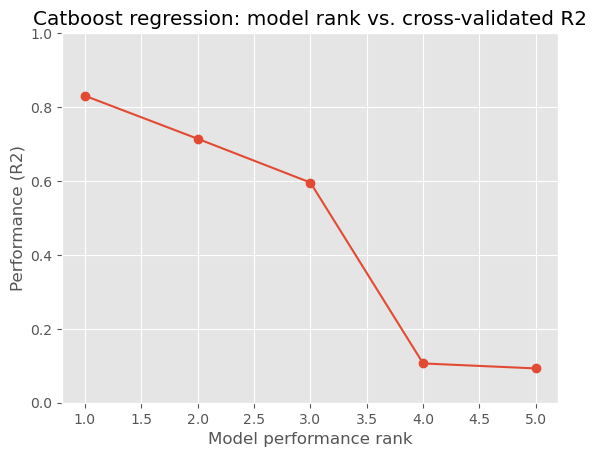

In [44]:
plt.plot(hyperparam_tuning_res['rank_test_score'], hyperparam_tuning_res['mean_test_score'], '-o')
plt.ylim(0, 1)
plt.xlabel('Model performance rank')
plt.ylabel('Performance (R2)')
plt.title('Catboost regression: model rank vs. cross-validated R2')
plt.show()

## Multi-Quantile Regression Example

CatBoost has built-in support for multi-quantile regression through the `MultiQuantile` loss function. E.g. to estimate (simultanuously) the 0.05 and 0.95th quantile, you can do: `'MultiQuantile:alpha=0.05, 0.95'`. To make this a bit easier for a general list of `alpha` values, let's make a helper function that generates these strings correctly.

In [62]:
def generate_catboost_mqr_loss_str(alpha_list: list[float]) -> str:
    """
    Generates the correct CatBoost loss function string for multi quantile regression
    based on a given list of alpha values. Note: it's also possible to give more than 2
    alpha values (e.g. 0.05; 0.5; 0.95).
    Args:
        alpha_list (list[float]): List of alpha values to estimate conditional quantile for.
        
    Returns:
        loss_fu_str (str): Loss function string for multi-quantile regression for CatBoost.
    """
    alpha_list_sorted = sorted(alpha_list)
    quantile_str = str(alpha_list_sorted).replace('[','').replace(']','')
    loss_fu_str = f"MultiQuantile:alpha={quantile_str}"
    return loss_fu_str

In [72]:
# Hyperparameter tuning for MULTI-QUANTILE Catboost regression
# Setting some general hyperparameter tuning parameters
n_folds = 3  # Amount of cross-validation folds
n_hyperparams = 5  # Amount of hyperparameters to sample (in case of RandomizedSearchCV)

# Defining loss function string
mqr_loss_function_str = generate_catboost_mqr_loss_str(alpha_list=[0.05, 0.95])
print(f"Multi-quantile loss function string: {mqr_loss_function_str}")

# Defining a hyperparameter grid
param_grid = {'depth': [2, 3, 4, 5, 6],
              'learning_rate': [0.001, 0.01, 0.1, 0.5],
              'iterations': [100, 200, 500]}

# Data splitter
k_fold = KFold(n_splits=n_folds)

# Initializing a CatBoostRegressor model
catboost_reg = CatBoostRegressor(loss_function=mqr_loss_function_str, 
                                 #cat_features=cat_feat_names, # This needs to specified here(*)
                                 random_seed=42, 
                                 verbose=0)

catboost_reg.fit(df_train_catboost)


Multi-quantile loss function string: MultiQuantile:alpha=0.05, 0.95


__Current issue seems to be that the multi-quantile regression doesn't play nicely with the Scikit-learn interface. Probably we can make it work better or more nicely if we give a 2-column target (just repeat it).__

In [1]:
# Hyperparameter tuning for MULTI-QUANTILE Catboost regression
# Setting some general hyperparameter tuning parameters
n_folds = 3  # Amount of cross-validation folds
n_hyperparams = 5  # Amount of hyperparameters to sample (in case of RandomizedSearchCV)

# Defining loss function string
mqr_loss_function_str = generate_catboost_mqr_loss_str(alpha_list=[0.05, 0.95])
print(f"Multi-quantile loss function string: {mqr_loss_function_str}")

# Defining a hyperparameter grid
param_grid = {'depth': [2, 3, 4, 5, 6],
              'learning_rate': [0.001, 0.01, 0.1, 0.5],
              'iterations': [100, 200, 500]}

# Data splitter
k_fold = KFold(n_splits=n_folds)

# Initializing a CatBoostRegressor model
catboost_reg = CatBoostRegressor(loss_function=mqr_loss_function_str, 
                                 cat_features=cat_feat_names, # This needs to specified here(*)
                                 random_seed=42, 
                                 verbose=0)

# Initializing a GridSearchCV or RandomizedSearchCV object
hyperparam_tuning = RandomizedSearchCV(estimator=catboost_reg,
                                       param_distributions=param_grid, 
                                       n_iter=n_hyperparams,
                                       cv=k_fold, 
                                       #scoring="r2", # or e.g. neg_root_mean_squared_error
                                       random_state=42,
                                       verbose=0)

# (*) Alternatively, if you don't specify cat_feats above, you can still run the fit() method as follows:
#hyperparam_tuning.fit(X=X_train[feats], 
#                      y=y_train, 
#                      **{'cat_features': cat_feats}) # Providing a dict with 'cat_features' as key

# Executing the hyperparameter tuning 
hyperparam_tuning.fit(X=X_train[feat_names],
                      y=y_train)
                      #pd.DataFrame({'SalePrice1': y_train, 'SalePrice2': y_train}))

# Extracting the hyperparameter tuning results (.cv_results_ attribute)
hyperparam_tuning_res = (pd.DataFrame(hyperparam_tuning.cv_results_)
                         .sort_values(by='rank_test_score', ascending=True)
                         .reset_index(drop=True))

NameError: name 'generate_catboost_mqr_loss_str' is not defined

In [82]:
import catboost; catboost.__version__

'1.2.3'

# Multi-class Classification Examples

In [46]:
# Read data
df = pd.read_csv("C:/Users/Vincent Wauters/Desktop/data_genus_level.csv",
                 sep=";",
                 decimal=",",
                 index_col=[0])
print(f"df.shape: {df.shape}")
display(df.head())

target_colname = "Group"
feat_colnames = [x for x in df.columns if x != target_colname]


df.shape: (1850, 30)


,Volume,ConvexHullVolume,CoreVolume,MaxLength,Solidity,CoreOccupacity,Flatness,DendriticDensity,AverageDendriticLength,PH_1,...,PH_12,PH_13,PH_14,PH_15,PH_16,PH_17,PH_18,PH_19,PH_20,Group
1,3947.4,10372.0,2467.1,78.098,0.38057,0.62498,0.39113,0.29450,5.2000,23.187,...,4.0849,2.0639,-5.4207,2.4408,-4.91970,-2.9442,0.22425,-0.283970,2.1986,Aegilops
2,5389.4,21079.0,2511.3,106.520,0.25567,0.46596,0.34523,0.37552,5.6950,36.117,...,3.6760,4.6085,4.9815,-1.1737,6.47890,4.3371,4.05900,0.052371,-3.3413,Aegilops
3,4350.8,16094.0,2540.5,123.950,0.27034,0.58391,0.32700,0.35500,3.9659,51.361,...,-1.2202,6.6608,5.7661,-4.6756,-0.58298,-6.0856,-4.37380,-3.345300,-1.9161,Aegilops
4,4252.2,12999.0,2570.7,72.676,0.32711,0.60456,0.49818,0.33023,3.9667,44.176,...,-5.5900,-0.5165,-2.0048,8.4974,-0.59045,-3.3714,-2.58810,1.268600,-5.9639,Aegilops
5,3015.1,10202.0,1781.8,90.372,0.29553,0.59096,0.40211,0.39836,4.0417,21.332,...,4.6530,3.6744,-1.4187,-2.1327,-2.39050,-4.4190,1.10420,0.019375,-1.8700,Aegilops


We use the scikit-learn `LabelEncoder` to correctly encode the target.

In [48]:
# Labelencoder for target
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y=df[target_colname])
y_train = le.transform(y=df[target_colname])
pd.Series(y_train).value_counts()  # Very irregular distribution
X_train = df[feat_colnames].copy()

In [50]:
# Hyperparameter tuning for Catboost regression
# Setting some general hyperparameter tuning parameters
n_folds = 3  # Amount of cross-validation folds
n_hyperparams = 5  # Amount of hyperparameters to sample (in case of RandomizedSearchCV)

# Defining a hyperparameter grid
param_grid = {'depth': [2, 3, 4, 5, 6],
              'learning_rate': [0.001, 0.01, 0.1, 0.5],
              'iterations': [100, 200, 500]}

# Initializing a CatBoostRegressor model
catboost_reg = CatBoostClassifier(loss_function="MultiClass", 
                                 cat_features=cat_feat_names, # This needs to specified here(*)
                                 random_seed=42, 
                                 verbose=0)

# Initializing a GridSearchCV or RandomizedSearchCV object
hyperparam_tuning = RandomizedSearchCV(estimator=catboost_reg,
                                       param_distributions=param_grid, 
                                       n_iter=n_hyperparams,
                                       cv=n_folds,  # Or supply make a KFold or similar object
                                       verbose=1)

# (*) Alternatively, if you don't specify cat_feats above, you can still run the fit() method as follows:
#hyperparam_tuning.fit(X=X_train[feats], 
#                      y=y_train, 
#                      **{'cat_features': cat_feats}) # Providing a dict with 'cat_features' as key

# Executing the hyperparameter tuning 
hyperparam_tuning.fit(X=X_train, 
                      y=y_train)

# Extracting the hyperparameter tuning results (.cv_results_ attribute)
hyperparam_tuning_res = (pd.DataFrame(hyperparam_tuning.cv_results_)
                        .sort_values(by='rank_test_score', ascending=True)
                        .reset_index(drop=True))

print(f"Optimally found hyperparameter values according to random search: {hyperparam_tuning_res['params'].iloc[0]}")

Fitting 3 folds for each of 5 candidates, totalling 15 fits
